# Импорт необходимых библиотек

In [25]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, Activation
from tensorflow.keras.models import Model
import os, numpy as np
from keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt

# Загрузка набора данных

In [ ]:
!pip install opendatasets --quiet

In [ ]:
import opendatasets as od

# Загрузка набора данных базы данных рентгенографии COVID-19
od.download("https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: sc1drofficial
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database


100%|██████████| 778M/778M [00:00<00:00, 1.33GB/s]


# Подготовим пути и проверим структуру папок
из папки `covid19-radiography-database/COVID-19_Radiography_Dataset/Normal`

In [8]:
import os

dataset_path = './covid19-radiography-database/COVID-19_Radiography_Dataset'
normal_path = os.path.join(dataset_path, 'Normal')

# Просмотрим содержимое
print(f"Найдено {len(os.listdir(normal_path))} изображений в папке 'Normal'")

Found 2 images in folder 'Normal'


In [11]:
dataset_path = 'covid19-radiography-database/COVID-19_Radiography_Dataset/Normal'

image_dir = 'images'
label_dir = 'masks'

# Визуализация данных

Посмотрим на данные, из которых состоит наш датасет. Для этого выведем изображения на экран с помощью знакомой нам функции `display()`:

In [15]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Входное изображение', 'Оригинальная маска', 'Предсказанная маска']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[0]))
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]),alpha=0.5)
    plt.axis('off')
  plt.show()

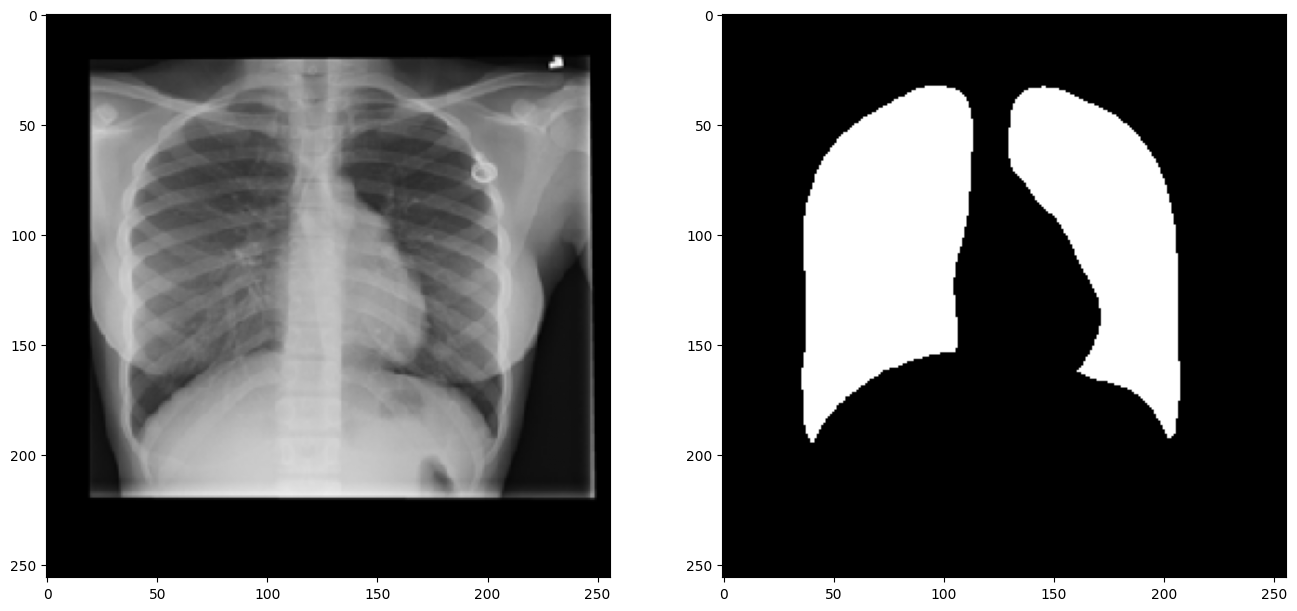

In [19]:
original_image = os.path.join(dataset_path, image_dir, 'Normal-1.png')
label_image_semantic = os.path.join(dataset_path, label_dir, 'Normal-1.png')

fig, axs = plt.subplots(1, 2, figsize=(16, 8))

img = np.array(load_img(original_image, target_size=(256, 256), color_mode='grayscale'))
mask = np.array(load_img(label_image_semantic, target_size=(256, 256), color_mode='grayscale'))

axs[0].imshow(img, cmap='gray')   # для рентгена
axs[0].grid(False)

axs[1].imshow(mask, cmap='gray')  # для маски (будет чёрно-белая)
axs[1].grid(False)

# Предобработка изображений

In [37]:
IMG_SIZE = 256
BATCH_SIZE = 10

image_dir = 'covid19-radiography-database/COVID-19_Radiography_Dataset/Normal/images'
mask_dir = 'covid19-radiography-database/COVID-19_Radiography_Dataset/Normal/masks'

image_paths = sorted([os.path.join(image_dir, f) for f in os.listdir(image_dir)])
mask_paths = sorted([os.path.join(mask_dir, f) for f in os.listdir(mask_dir)])

In [38]:
def process_image_mask(image_path, mask_path):
    image = load_img(image_path, color_mode='grayscale', target_size=(IMG_SIZE, IMG_SIZE))
    image = img_to_array(image) / 255.0
    image = np.repeat(image, 3, axis=-1)  # -> (256, 256, 3)

    mask = load_img(mask_path, color_mode='grayscale', target_size=(IMG_SIZE, IMG_SIZE))
    mask = img_to_array(mask)[:, :, 0]
    mask = np.where(mask > 127, 1.0, 0.0).astype(np.float32)

    return image, mask[..., np.newaxis]


# Подготовка датасета

In [39]:
def tf_dataset(image_paths, mask_paths, batch_size=BATCH_SIZE):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, mask_paths))

    def _map_fn(img_path, msk_path):
        img, msk = tf.numpy_function(process_image_mask, [img_path, msk_path], [tf.float32, tf.float32])
        img.set_shape([IMG_SIZE, IMG_SIZE, 3])
        msk.set_shape([IMG_SIZE, IMG_SIZE, 1])
        return img, msk

    dataset = dataset.map(_map_fn, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.shuffle(buffer_size=100)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

train_dataset = tf_dataset(image_paths, mask_paths)

# Создание U-Net модели

In [40]:
def build_auto_unet(input_shape=(IMG_SIZE, IMG_SIZE, 3)):
    inputs = Input(input_shape)

    # Encoder
    x = Conv2D(32, 3, activation='relu', padding='same')(inputs)
    x = MaxPooling2D()(x)
    x = Conv2D(64, 3, activation='relu', padding='same')(x)
    x = MaxPooling2D()(x)
    x = Conv2D(128, 3, activation='relu', padding='same')(x)
    x = MaxPooling2D()(x)

    # Bottleneck
    x = Conv2D(256, 3, activation='relu', padding='same')(x)

    # Decoder
    x = Conv2DTranspose(128, 3, strides=2, activation='relu', padding='same')(x)
    x = Conv2DTranspose(64, 3, strides=2, activation='relu', padding='same')(x)
    x = Conv2DTranspose(32, 3, strides=2, activation='relu', padding='same')(x)

    outputs = Conv2D(1, 1, activation='sigmoid')(x)

    return Model(inputs, outputs)

model = build_auto_unet()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 256, 256, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 64, 64, 128)    │       295,040 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 128, 128, 64)   │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_5              │ (None, 256, 256, 32)   │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 256, 256, 1)    │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 775,745 (2.96 MB)

 Trainable params: 775,745 (2.96 MB)

 Non-trainable params: 0 (0.00 B)

# Обучение модели

In [41]:
history = model.fit(train_dataset, epochs=15)

Epoch 1/15
1020/1020 ━━━━━━━━━━━━━━━━━━━━ 39s 31ms/step - accuracy: 0.8893 - loss: 0.2623
Epoch 2/15
1020/1020 ━━━━━━━━━━━━━━━━━━━━ 29s 28ms/step - accuracy: 0.9825 - loss: 0.0468
Epoch 3/15
1020/1020 ━━━━━━━━━━━━━━━━━━━━ 28s 28ms/step - accuracy: 0.9880 - loss: 0.0312
Epoch 4/15
1020/1020 ━━━━━━━━━━━━━━━━━━━━ 28s 28ms/step - accuracy: 0.9899 - loss: 0.0262
Epoch 5/15
1020/1020 ━━━━━━━━━━━━━━━━━━━━ 28s 28ms/step - accuracy: 0.9911 - loss: 0.0227
Epoch 6/15
1020/1020 ━━━━━━━━━━━━━━━━━━━━ 28s 28ms/step - accuracy: 0.9920 - loss: 0.0200
Epoch 7/15
1020/1020 ━━━━━━━━━━━━━━━━━━━━ 28s 28ms/step - accuracy: 0.9925 - loss: 0.0190
Epoch 8/15
1020/1020 ━━━━━━━━━━━━━━━━━━━━ 28s 28ms/step - accuracy: 0.9922 - loss: 0.0198
Epoch 9/15
1020/1020 ━━━━━━━━━━━━━━━━━━━━ 28s 28ms/step - accuracy: 0.9934 - loss: 0.0164
Epoch 10/15
1020/1020 ━━━━━━━━━━━━━━━━━━━━ 28s 28ms/step - accuracy: 0.9924 - loss: 0.0193
Epoch 11/15
1020/1020 ━━━━━━━━━━━━━━━━━━━━ 28s 28ms/step - accuracy: 0.9938 - loss: 0.0154
Epoch 12

# Визуализация результата

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 828ms/step


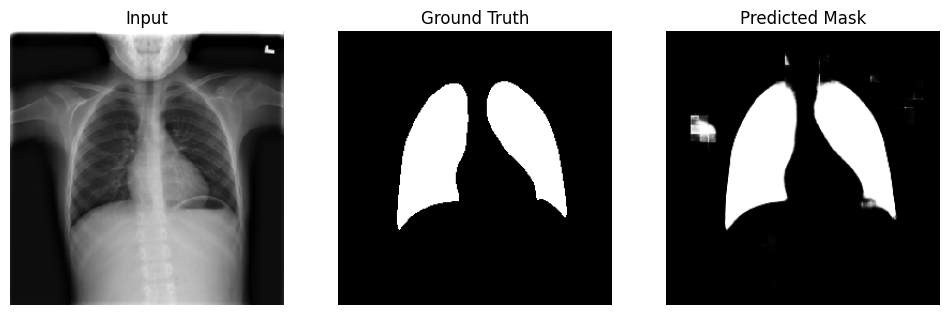

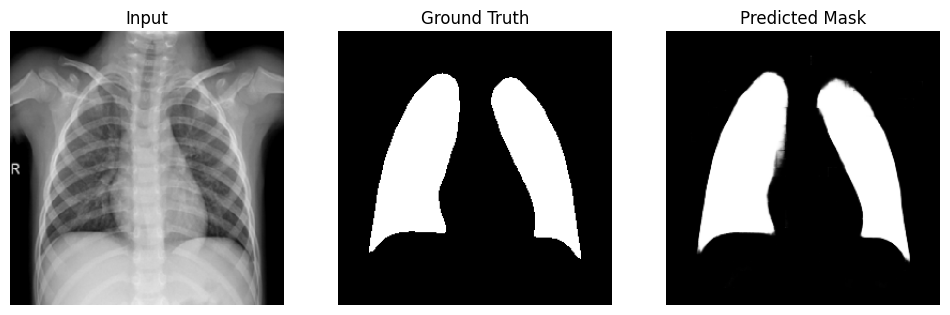

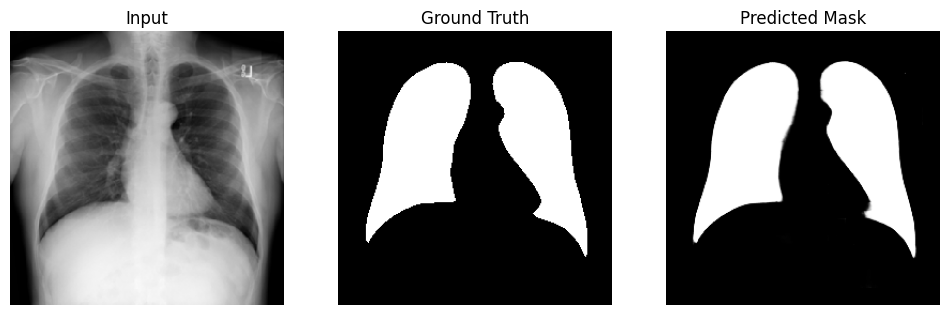

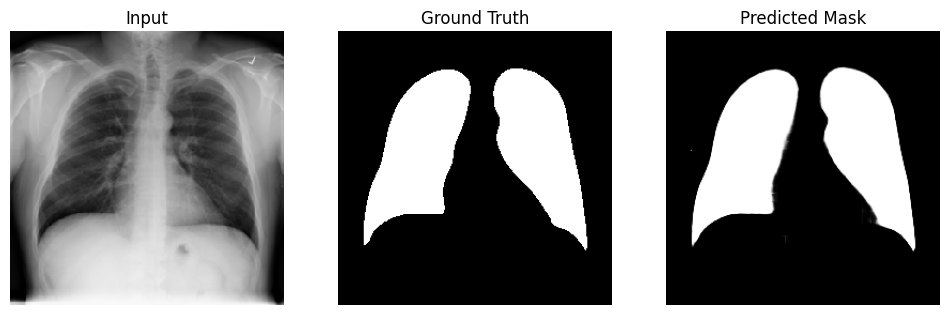

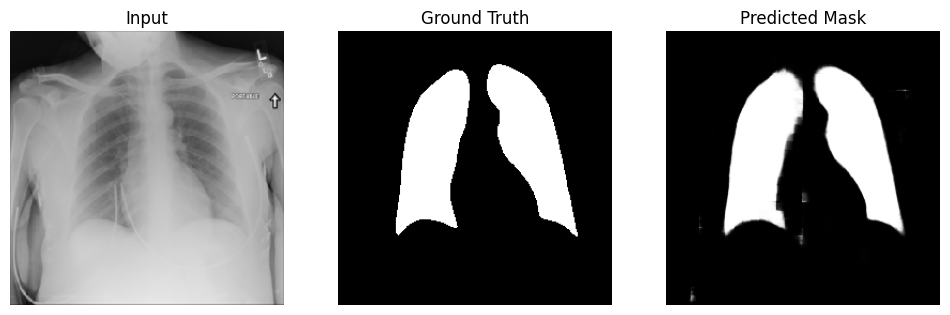

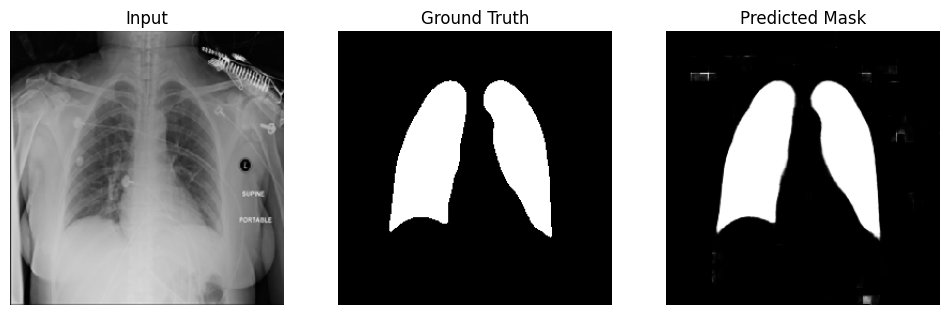

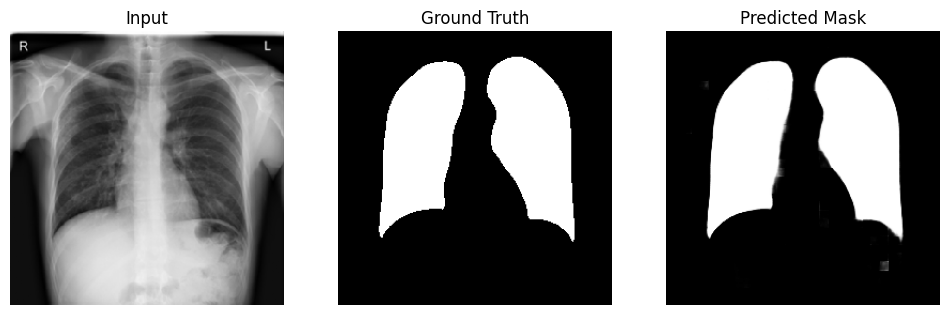

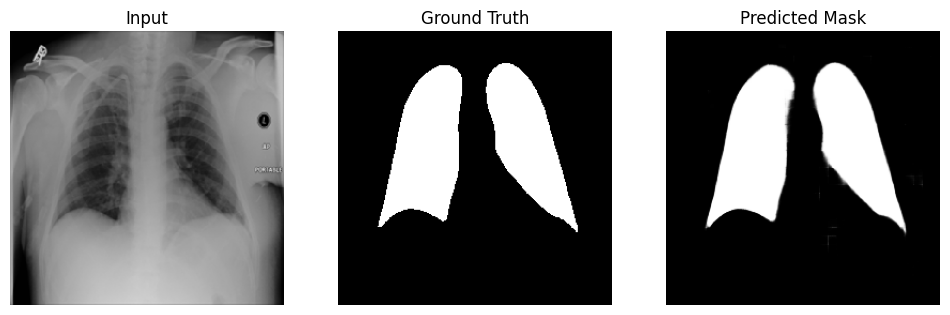

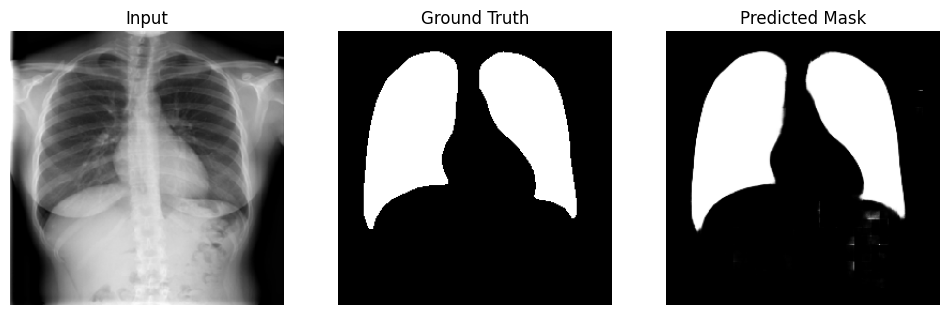

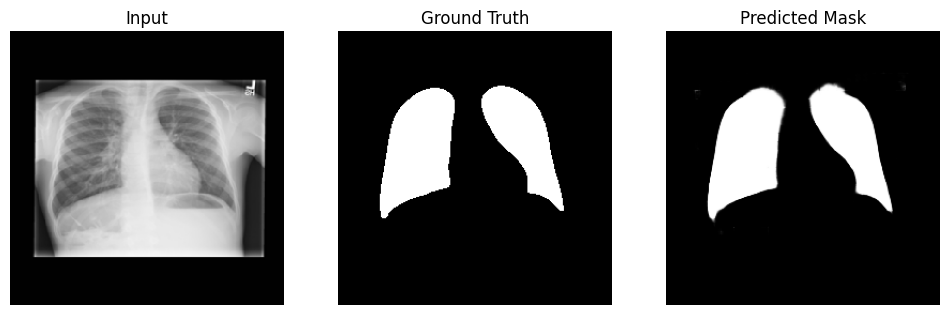

In [42]:
def display_prediction(model, dataset):
    for images, masks in dataset.take(1):
        preds = model.predict(images)
        for i in range(10):
            plt.figure(figsize=(12, 4))

            plt.subplot(1, 3, 1)
            plt.title("Input")
            plt.imshow(images[i].numpy().squeeze(), cmap='gray')
            plt.axis('off')

            plt.subplot(1, 3, 2)
            plt.title("Ground Truth")
            plt.imshow(masks[i].numpy().squeeze(), cmap='gray')
            plt.axis('off')

            plt.subplot(1, 3, 3)
            plt.title("Predicted Mask")
            plt.imshow(preds[i].squeeze(), cmap='gray')
            plt.axis('off')
            plt.show()

display_prediction(model, train_dataset)

# Вывод по визуализации сегментации лёгких

В результате обучения U-Net-подобной архитектуры на рентгеновских снимках грудной клетки из папки Normal была проведена визуальная оценка качества сегментации. На изображениях представлены входные снимки, соответствующие истинные маски (Ground Truth) и предсказанные моделью маски (Predicted Mask).

Визуализация демонстрирует, что модель успешно обучилась выделять области лёгких:

* Предсказанные маски хорошо совпадают с истинными по форме и расположению.

* Модель корректно определяет границы правого и левого лёгкого, включая характерные анатомические особенности.

* Незначительные артефакты и размытия наблюдаются в области средостения, однако они несущественно влияют на итоговую структуру маски.

Таким образом, визуальный анализ подтверждает, что модель справляется с задачей сегментации лёгких на снимках с нормальным состоянием, а качество предсказаний можно считать удовлетворительным для последующего применения или дальнейшего улучшения.